# Frequency Differencing with Raw Data

This script demonstrates the use of numeric and boolean operators on ProcessedData and Mask objects. It also provides an example using the ProcessedData.zeros_like() method to get a ProcessedData array we can use to fill with the results of our analysis.  Lastly, it shows how to use the ProcessedData.view() method to plot subsets of the data.

## Initialization
If you do not already have __pyEcholab__ installed using the following pip command in the terminal to install it:
```
pip install git+https://github.com/CI-CMG/pyEcholab.git
```

In [1]:
from echolab2.instruments import EK60
from echolab2.plotting.matplotlib import echogram
from echolab2.processing import mask, line
import numpy as np
import os

To access the data we will use the library boto3, which provides an object-oriented interface to Amazon S3 Buckets. We configure the boto3 resource to access the bucket as an anonymous user.

In [2]:
import boto3, botocore
from botocore import UNSIGNED
from botocore.client import Config

s3 = boto3.resource('s3', aws_access_key_id='', aws_secret_access_key='', config=Config(signature_version=UNSIGNED))

BUCKET = 'cires'

## Read S3 Data
We will download files from the bucket, caching them in the local directory for later use. If they already have been downloaded, they will be cached for subsequent use.

In [3]:
rawFiles = [
    'DY1706_EK60-D20170625-T062521.raw',
    'DY1706_EK60-D20170625-T063335.raw',
    'DY1706_EK60-D20170625-T064148.raw'
]
bottomFiles = [
    'DY1706_EK60-D20170625-T062521.bot',
    'DY1706_EK60-D20170625-T063335.bot',
    'DY1706_EK60-D20170625-T064148.bot'
]

try:
    for file in rawFiles + bottomFiles:
        if file not in os.listdir('.'): 
            s3.Bucket(BUCKET).download_file('data/raw/EK60/' + file, file)
            print('downloaded:', file)
        else:
            print('already found:', file)
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

already found: DY1706_EK60-D20170625-T062521.raw
already found: DY1706_EK60-D20170625-T063335.raw
already found: DY1706_EK60-D20170625-T064148.raw
already found: DY1706_EK60-D20170625-T062521.bot
already found: DY1706_EK60-D20170625-T063335.bot
already found: DY1706_EK60-D20170625-T064148.bot


## Create an instance of a pyEcholab EK60 class

In [4]:
ek60 = EK60.EK60()
type(ek60)

echolab2.instruments.EK60.EK60

##  Parse and mask the data
Reading the raw files and store data for 18, 38, and 120 kHz.

In [5]:
print('Reading the raw files...')
ek60.read_raw(rawFiles, frequencies=[18000, 38000, 120000])

Reading the raw files...


Read the botom files.

In [6]:
print('Reading the bottom files...')
ek60.read_bot(bottomFiles)

Reading the bottom files...


Get the raw_data objects from ek60. We will call "get_raw_data" with no arguments to get a dictionary keyed by channel id of all the channels in the data.

In [7]:
raw_data = ek60.get_raw_data()
raw_data

{'GPT  18 kHz 009072034d45 1-1 ES18-11': <echolab2.instruments.EK60.RawData at 0x105d8a5d0>,
 'GPT  38 kHz 009072033fa2 2-1 ES38B': <echolab2.instruments.EK60.RawData at 0x1110ec650>,
 'GPT 120 kHz 00907205794e 4-1 ES120-7C': <echolab2.instruments.EK60.RawData at 0x1110f4450>}

Get the __Sv__ for the frequencies we're looking for and put in a dictionary keyed by frequency. Note: this approach will not work if there are multiple channels with the same frequency.

In [8]:
Sv_data = {18000: None, 38000: None, 120000: None}

bottom_lines = {18000: None, 38000: None, 120000: None}

for chan_id in raw_data:
    if (raw_data[chan_id].frequency[0] in Sv_data.keys()):
        # get Sv and assign it to our dictionary
        Sv_data[raw_data[chan_id].frequency[0]] = raw_data[chan_id].get_Sv()
        print(Sv_data[raw_data[chan_id].frequency[0]])
        bottom_lines[raw_data[chan_id].frequency[0]] = raw_data[chan_id].get_bottom()

<class 'echolab2.processing.processed_data.ProcessedData'> at 0x105d8a190
                channel(s): [GPT  18 kHz 009072034d45 1-1 ES18-11]
                 frequency: 18000.0
           data start time: 2017-06-25T06:25:21.886
             data end time: 2017-06-25T06:50:03.298
            number of pings: 1476
            data attributes: ping_time (1476)
                            data (1476,5293)
                            range (5293)

<class 'echolab2.processing.processed_data.ProcessedData'> at 0x105d8eb50
                channel(s): [GPT  38 kHz 009072033fa2 2-1 ES38B]
                 frequency: 38000.0
           data start time: 2017-06-25T06:25:21.886
             data end time: 2017-06-25T06:50:03.298
            number of pings: 1476
            data attributes: ping_time (1476)
                            data (1476,5293)
                            range (5293)

<class 'echolab2.processing.processed_data.ProcessedData'> at 0x115b819d0
                channel(s): [GPT

## Masks
Now create a mask for each frequency and apply surface and bottom lines to these masks such that we remove samples near the surface and below the bottom.  We will actually mask the first 0.5 meters beneath the surface.

First create a surface line.  Note the scalar value, __0.5__.

In [9]:
masks = {18000: None, 38000: None, 120000: None}
for freq in Sv_data.keys():
    # create a mask
    masks[freq] = mask.Mask(like=Sv_data[freq])
    # mirror a line that 0.5 meters lower (in place operators will change the existing line)
    bot_line = bottom_lines[freq] - 0.5
    # create a surface exclusion line at the 10 meter RANGE.
    surf_line = line.Line(ping_time=Sv_data[freq].ping_time, data=10)
    # apply that line to our mask
    # we apply the value True BELOW our line
    masks[freq].apply_line(bot_line, apply_above=False)
    # now apply our surface line to this same mask
    masks[freq].apply_line(surf_line, apply_above=True)
    # use this mask to set sample data from 0.5m above the bottom downward to NaN
    Sv_data[freq][masks[freq]] = np.nan

## Frequency Differencing
Now lets compute some differences. The ProcessData class implements arithmetic operators so we can simply subtract ProcessData objects like numeric objects.  Both, "regular": {+, -, *, /}  and  "in-place": {+=, -=, *=, /=} operators are implemented.  Regular operators return a new ProcessedData object with the same general properties containing the results of your operation. The in-place operators will alter the data in the left-hand side of the argument.

First we will do some preprocessing to remove data with a signal less than -80 dB.

In [10]:
print('120 kHz min:', np.round(np.nanmin(Sv_data[120000].data), 2),
      '\n120 kHz max:', np.round(np.nanmax(Sv_data[120000].data), 2), '\n'
     )
print('18 kHz min:', np.round(np.nanmin(Sv_data[18000].data), 2),
      '\n18 kHz max:', np.round(np.nanmax(Sv_data[18000].data), 2)
     )

120 kHz min: -140.13 
120 kHz max: -25.81 

18 kHz min: -139.54 
18 kHz max: -18.9


Remove all values less than or equal to -80 dB. The data is stored in a numpy ndarray.

In [11]:
print('shape:', Sv_data[120000].data.shape)
arr = Sv_data[120000].data
clipArray = np.full(arr.shape, -80)
clipped = np.maximum(arr, clipArray)
Sv_data[120000].data = clipped

print(
    '120 kHz min:', np.round(np.nanmin(Sv_data[120000].data), 2),
    '\n120 kHz max:', np.round(np.nanmax(Sv_data[120000].data), 2)
    )

shape: (1476, 5293)
120 kHz min: -80.0 
120 kHz max: -25.81


Subtract 18 kHz from 120 kHz

In [12]:
Sv_120m18 = Sv_data[120000] - Sv_data[18000]

We can now calculate the range of the resulting difference:

In [13]:
print('min:', np.round(np.nanmin(Sv_120m18.data), 2), '\nmax:', np.round(np.nanmax(Sv_120m18.data), 2))

min: -43.67 
max: 64.42


## Plotting

Plot the original data. Use the "view" method to return a ProcessedData object that is a view of the original data. We will plot all pings and samples from 0 to 2000.

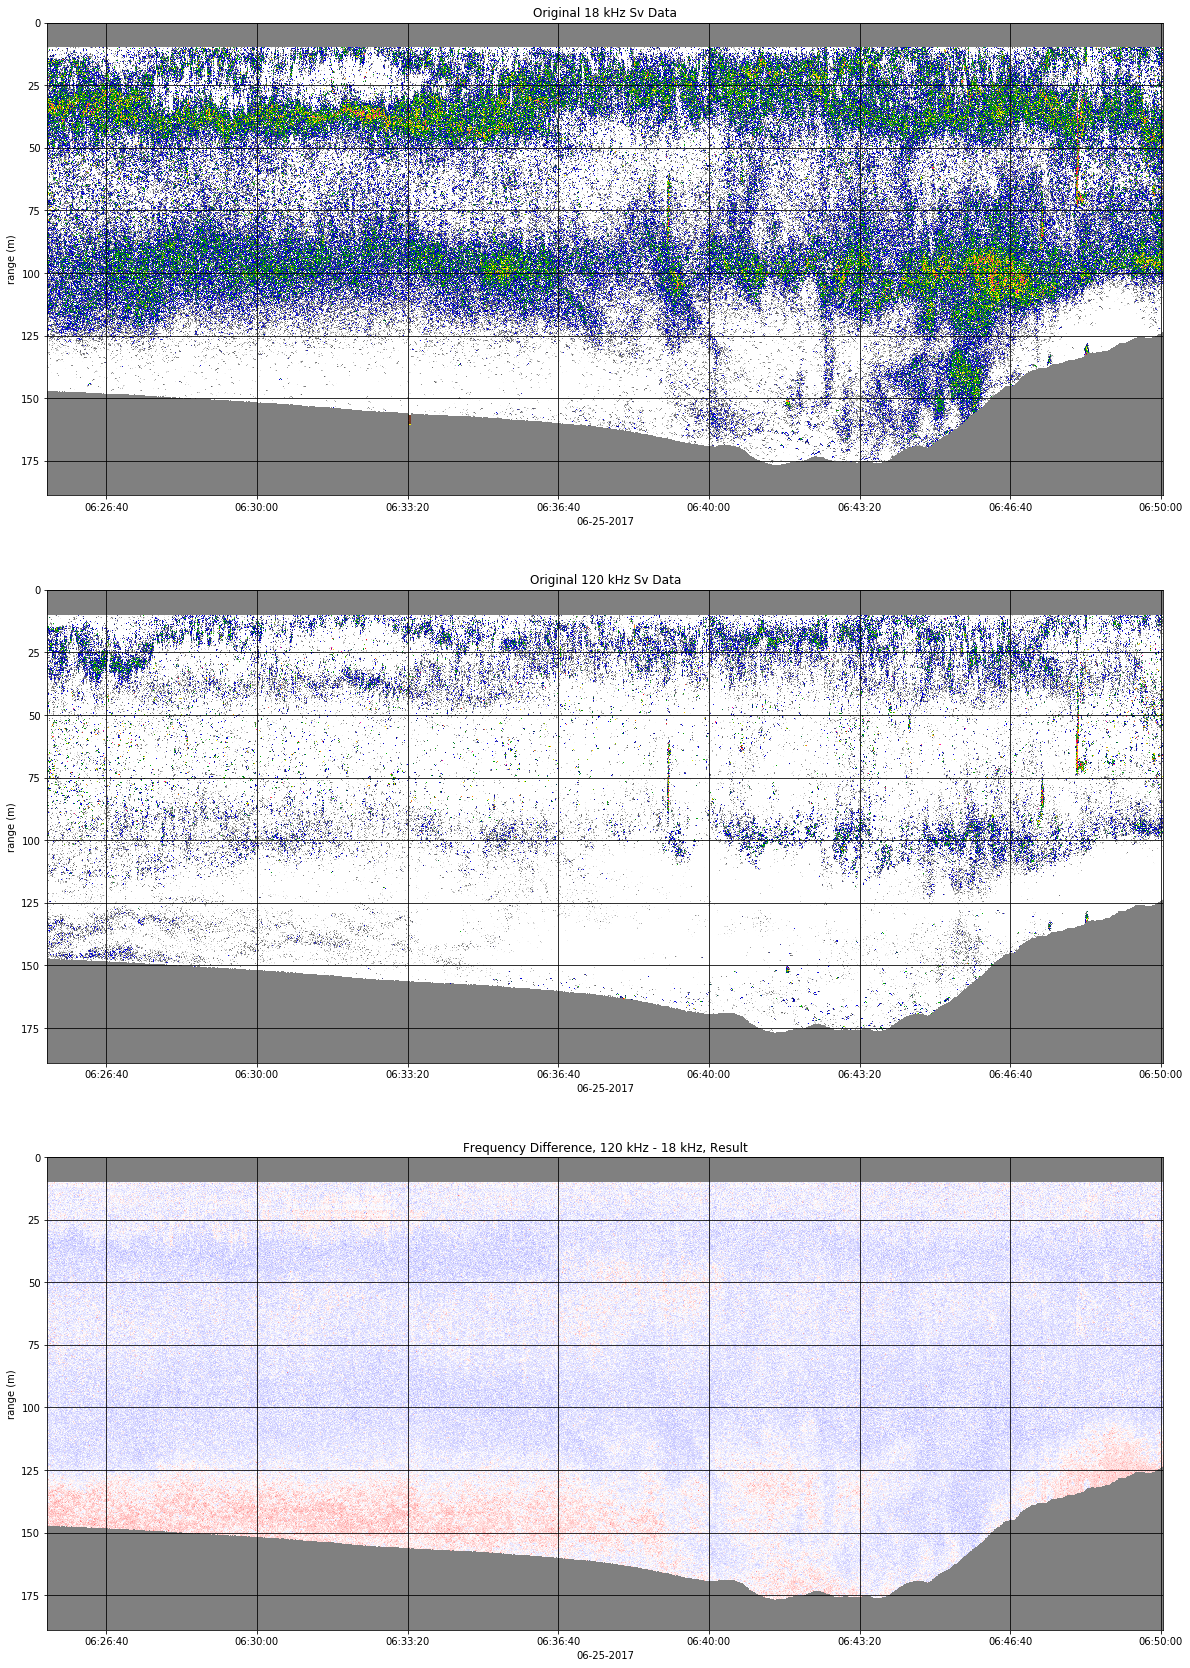

In [15]:
import matplotlib
from matplotlib.pyplot import figure, show, set_cmap, colorbar

fig = figure(figsize=[20, 40])
ax = fig.add_subplot(4, 1, 1)

v_data = Sv_data[18000].view((None, None, None),(0, 2000, None))
eg = echogram.Echogram(ax, v_data, threshold=[-70, -34])
ax.set_title("Original 18 kHz Sv Data")

ax = fig.add_subplot(4, 1, 2)
v_data = Sv_data[120000].view((None, None, None), (0, 2000, None))
eg = echogram.Echogram(ax, v_data, threshold=[-70, -34])
ax.set_title("Original 120 kHz Sv Data")

# plot our differenced data
ax = fig.add_subplot(4, 1, 3)
v_results = Sv_120m18.view((None, None, None), (0, 2000, None))

# note: we set the threshold to something that will work with the values we assigned to our results.
eg = echogram.Echogram(ax, v_results, threshold=[-100, 100], cmap=matplotlib.pyplot.get_cmap('bwr'))
ax.set_title('Frequency Difference, 120 kHz - 18 kHz, Result')

show()